In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

Решаем дифур $̇\ddot{x} = f(x,t)$
$f = \vec{g}$

Решать мудем явным методом Рунге-Куты 4 порядка
Отдельно стоит отметить, что, во первых, систему ДУ не является жесткой, поэтому использование явного метода целесообразно. Во-вторых, ожидаемые решения принадлежат области устойчивости ЯМРК(4)
$$ЯМРК(4):$$
$$\vec{X_{n + 1}} = \vec{X_n} + h/6 * (\vec{q_1} + 2 \vec{q_2} + 2 \vec{q_3} + \vec{q_4})$$

Выжные для моделирования Земли константы и некотрые вспомогательные функции

In [ ]:
GM = 3.986004418 * 10**14
c0 = 2.202095 * 10**10
omega = 7.292115*10**(-5)
#В данных вами документах не нашел баллистического коэффициента, поэтому подобрал сам из тех соображений, чтобы падающая вертикально вниз без начальной скорости ракета набирала скорость,
#которая мне показалась реалистичной
gamma = 0.0000411
f = 298.3
e = np.sqrt((2*f-1) / (f-1)**2)
a = 6378245

def s(x):
     return x[2] / r0(x)
def h(x):
    return r0(x) - a / (np.sqrt(1 + e**2 * s(x)**2))
def rho(H):
    return 1.41*np.exp(-H/6910)
def r0(x):
    return np.sqrt(x[0]**2+x[1]**2+x[2]**2)

def g_0(x):
    return  -GM / (r0(x)**3) * (np.array(x) - 3 * c0 / (r0(x)**2) * np.array(x) - 6 * c0 / (r0(x)**2) * np.array([0, 0, x[2]]) + 15 * c0 / (r0(x)**4) * np.array(x) * x[2]**2)

def g_ca(x):
    return omega**2 * np.array(x)

def g_cor(v):
    return 2*omega * np.array([v[1], -v[0], 0])

def g_aer(x,v):
    return -gamma * rho(h(x)) * np.sqrt(v[0]**2 + v[1]**2 + v[2]**2) /2 *np.array([v[0], v[1], v[2]])

def g(x, v):
    return  g_0(x) + g_ca(x) + g_cor(v) + g_aer(x,v)
    #return np.array([-10, 0, 0])

Шаг дискретизации для работу ЯМРК

In [ ]:
dt = 0.1

Коэффициенты ЯМРК и его реализация

In [ ]:
def k_1(x_n, v_n):
     return g(x_n, v_n)
def q_1(x_n, v_n):
    return np.array(v_n)
def k_2(x_n, v_n):
    return np.array(g(x_n + dt / 2 * q_1(x_n, v_n), v_n + dt / 2 * k_1(x_n, v_n)))
def q_2(x_n, v_n):
    return q_1(x_n, v_n) + k_1(x_n, v_n) * dt / 2
def k_3(x_n, v_n):
    return g(x_n + dt / 2 * q_2(x_n, v_n), v_n + dt / 2 * k_2(x_n, v_n))
def q_3(x_n, v_n):
    return q_1(x_n, v_n) + k_2(x_n, v_n) * dt / 2
def k_4(x_n, v_n):
    return g(x_n + dt * q_3(x_n, v_n), v_n + dt * k_3(x_n, v_n))
def q_4(x_n, v_n):
    return q_1(x_n, v_n) + k_3(x_n, v_n) * dt

def RMRK_4(x_0, v_0):
    n = 1
    x_n = [0,0,0]
    x_n = x_0
    v_n = [0,0,0]
    v_n = v_0
    data_x = [x_0]
    data_v = [v_0]
    #data_x = np.zeros(n)
    #data_v = np.zeros(n)
    #data_x.append(x_n)
    #data_v.append(v_n)
    while(True):
        # Evaluate for coefficients
        k1 = k_1(x_n, v_n)
        k2 = k_2(x_n, v_n)
        k3 = k_3(x_n, v_n)
        k4 = k_4(x_n, v_n)
        q1 = q_1(x_n, v_n)
        q2 = q_2(x_n, v_n)
        q3 = q_3(x_n, v_n)
        q4 = q_4(x_n, v_n)
        # Next iteration
        v_n1 = v_n + dt/6 * (k1+2*k2+2*k3+k4)
        x_n1 = x_n + dt/6 * (q1+2*q2+2*q3+q4)
        #костыль с n > 10000 нужен для тех случаев, когда начальные условия таковы, что ракета либо мгновенно врезется в землю,
        #либо наоборот, имея первую космическую скорость, покидает Землю
        if (h(x_n1) <= 0 or n > 10000):
            break
        n+=1

        x_n = x_n1
        v_n = v_n1
        data_x.append(x_n)
        data_v.append(v_n)

    return data_x, data_v, n

Найдем начало МЗСК и Точку пуска ракеты в МЗСК

In [ ]:
#Такие долгота и широта выбраны исключительно для наглядности графика в 3D
#phi_0 = phi
#phi' = phi
phi_0 = 10 / 180 * np.pi
lamda_0 = 0 / 180 * np.pi
H = 50
phi = np.arctan((1-1/f)**2*np.tan(phi_0))
r_0 = a / np.sqrt(1 + (1 / (1 - 1 / f)**2 - 1) * np.sin(phi_0)**2)
x_0 = np.array([r_0*np.cos(phi)*np.cos(lamda_0) + H*np.cos(phi_0)*np.cos(lamda_0), r_0*np.cos(phi)*np.sin(lamda_0) + H*np.cos(phi_0)*np.sin(lamda_0), r_0 * np.sin(phi) + H *np.sin(phi_0)])
A_mg = np.array([[-np.cos(lamda_0)* np.sin(phi_0), -np.sin(lamda_0)*np.sin(phi_0), np.cos(phi_0)],
[np.cos(lamda_0)* np.cos(phi_0), np.sin(lamda_0)* np.cos(phi_0), np.sin(phi_0)],
[np.sin(lamda_0), np.cos(lamda_0), 0]])

Начальная скорость, записанная в ГПСК

In [ ]:
v_0 = np.array([100,300, 100])

In [ ]:
def g_to_m_conv(x):
    H = 0
    x_0 = np.array([r_0*np.cos(phi)*np.cos(lamda_0) + H*np.cos(phi_0)*np.cos(lamda_0), r_0*np.cos(phi)*np.sin(lamda_0) + H*np.cos(phi_0)*np.sin(lamda_0), r_0 * np.sin(phi) + H *np.sin(phi_0)])
    return A_mg @ (x - x_0)
def m_to_g_conv(x):
    return np.array(x_0) + A_mg.T @ x


Функции для обработки набора координат в ГПСК для построения графиков

In [ ]:
def analysis(data_x, data_v):
    data_r = []
    data_h = []
    data_v2 = []
    data_g = []
    for i in range (0, len(data_x)-1):
        data_h.append(h(data_x[i]))
        data_r.append(r0(g_to_m_conv(data_x[i])))
        data_v2.append(r0(data_v[i]))
        data_g.append(r0(g(data_x[i], data_v[i])))
    return data_r, data_h, data_v2, data_g

def convert_x(data_x):
    result_x = []
    result_y = []
    result_z = []
    for i in range (0, len(data_x) - 1):
        result_x.append(g_to_m_conv( data_x[i])[0])
        result_y.append(g_to_m_conv( data_x[i])[1])
        result_z.append(g_to_m_conv( data_x[i])[2])
    return result_x, result_y, result_z

In [ ]:
data = RMRK_4(x_0, v_0)
data_x = data[0]
data_v = data[1]
n = data[2]
t = (n-1.5) * dt
data_t = np.arange(0,t,dt)
data_r, data_h, data_v2, data_g = analysis(data_x, data_v)
print("Число отчетов для моделирования:", n)

Число отчетов для моделирования: 235


Построение всех необходимых графиков

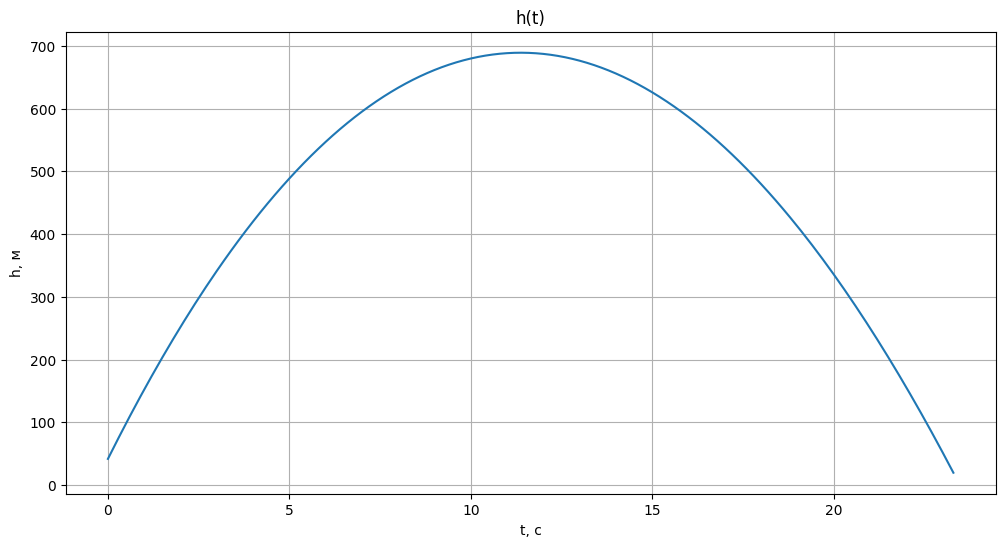

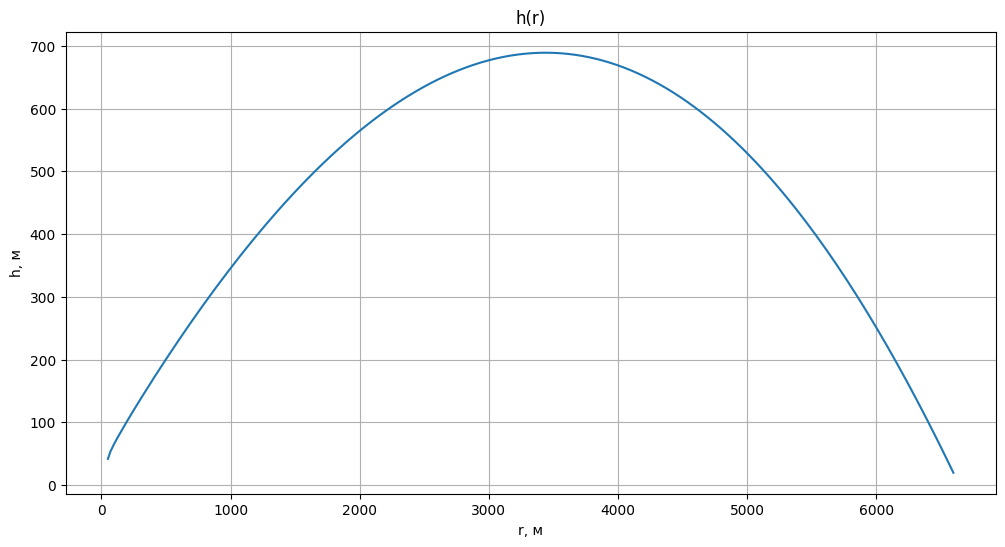

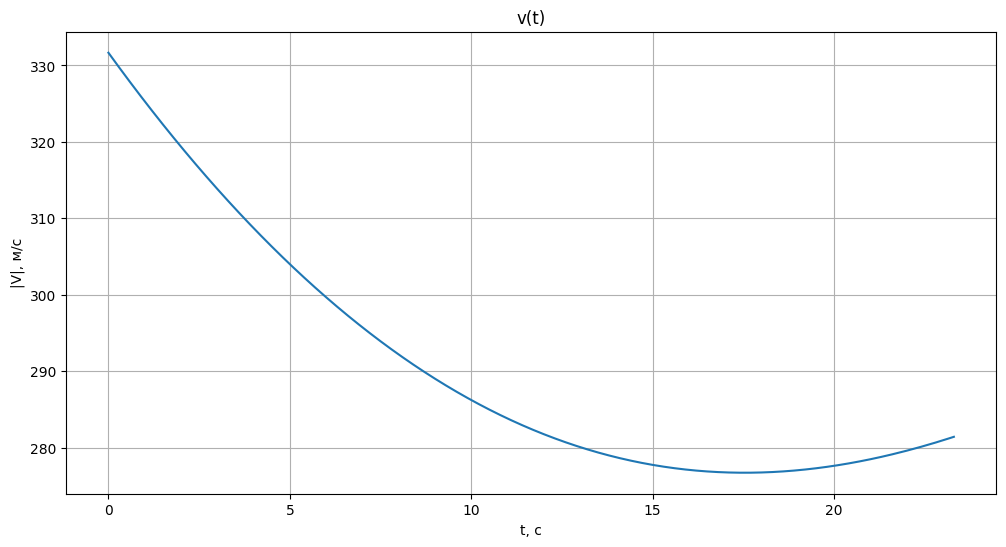

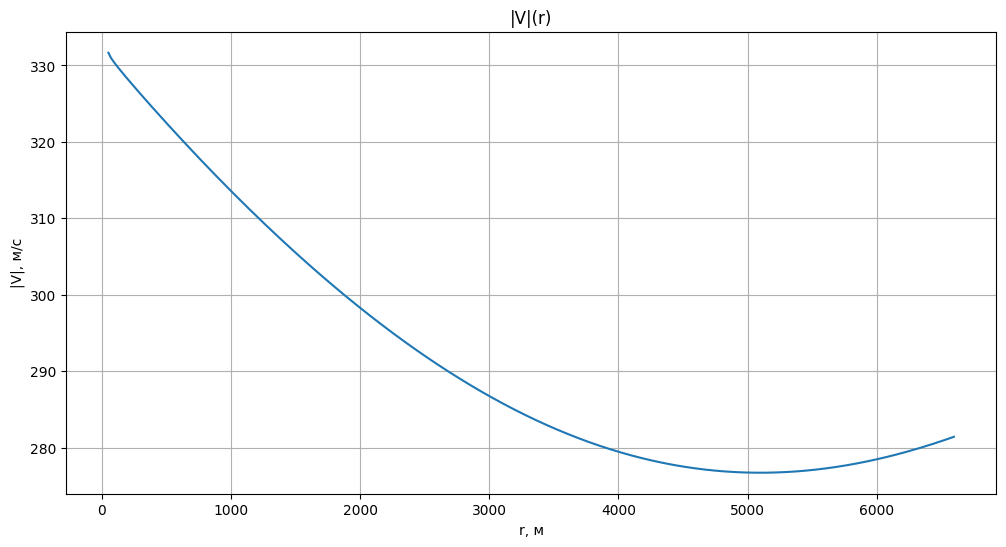

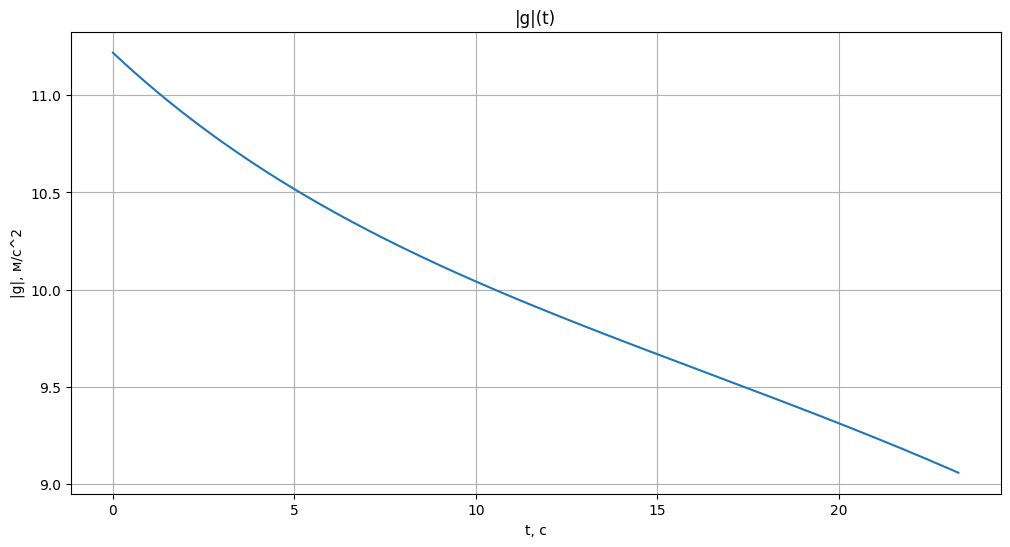

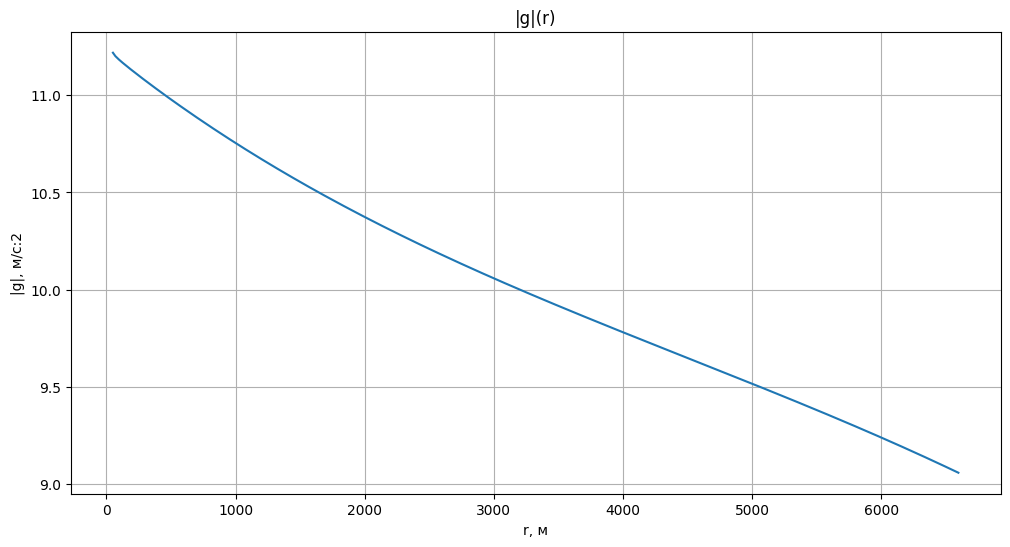

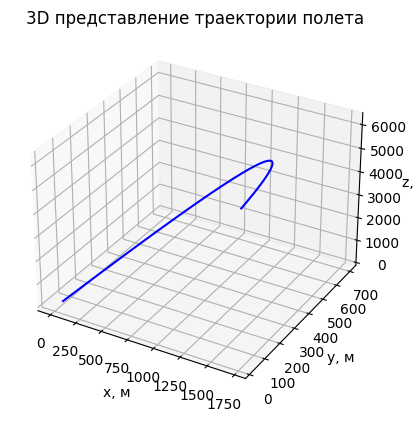

In [ ]:
plt.figure (figsize=[12, 6])
plt.title ("h(t)")
plt.plot (data_t,data_h)
plt.xlabel ("t, c")
plt.ylabel ("h, м")
plt.grid ()
plt.show ()

plt.figure (figsize=[12, 6])
plt.title ("h(r)")
plt.plot (data_r,data_h)
plt.xlabel ("r, м")
plt.ylabel ("h, м")
plt.grid ()
plt.show ()

plt.figure (figsize=[12, 6])
plt.title ("v(t)")
plt.plot (data_t, data_v2)
plt.xlabel ("t, с")
plt.ylabel ("|V|, м/с")
plt.grid ()
plt.show ()

plt.figure (figsize=[12, 6])
plt.title ("|V|(r)")
plt.plot (data_r,data_v2)
plt.xlabel ("r, м")
plt.ylabel ("|V|, м/с")
plt.grid ()
plt.show ()

plt.figure (figsize=[12, 6])
plt.title ("|g|(t)")
plt.plot (data_t,data_g)
plt.xlabel ("t, с")
plt.ylabel ("|g|, м/с^2")
plt.grid ()
plt.show ()

plt.figure (figsize=[12, 6])
plt.title ("|g|(r)")
plt.plot (data_r,data_g)
plt.xlabel ("r, м")
plt.ylabel ("|g|, м/с:2")
plt.grid ()
plt.show ()


fig = plt.figure()
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.set_xlabel('x, м')
ax.set_ylabel('y, м')
ax.set_zlabel('z, м')
# defining all 3 axis
x,y,z = convert_x(data_x)
# plotting
ax.plot3D(x, y, z, 'blue')
ax.set_title('3D представление траектории полета')
plt.show()

